<a href="https://colab.research.google.com/github/cteliStolenFocus/aai-510-team_yash_olympia_chris/blob/main/Final_Project_SU23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import os, sys
import gc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyClassifier
import lazypredict
#Liblaries for cross validation and model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Path used for data storage
default_dir = "/content/aai-510-team_yash_olympia_chris/"

In [5]:
# Reading data from github for the project
!git clone https://github.com/cteliStolenFocus/aai-510-team_yash_olympia_chris

Cloning into 'aai-510-team_yash_olympia_chris'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 39 (delta 9), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (39/39), 1.13 MiB | 5.72 MiB/s, done.


## greeks.csv - Supplemental metadata, only available for the training set.

##    Alpha Identifies the type of age-related condition, if present.
##

1.   A No age-related condition. Corresponds to class 0.
2.   B, D, G The three age-related conditions. Correspond to class 1.

Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [9]:
greeks_data = pd.read_csv(os.path.join(default_dir,'greeks.csv'))

print(f'greeks Data Shape: {greeks_data.shape}')

greeks_data.head()

greeks Data Shape: (617, 6)


,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


train.csv - The training set.

*   Id Unique identifier for each observation.
*   AB-GL 56 anonymized health characteristics. All are numeric except  for EJ, which is categorical.
*   Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions
*   0 indicates they have not.



In [10]:
train_df = pd.read_csv(os.path.join(default_dir,'train.csv'))

print(f'Training Data Shape: {train_df.shape}')

train_df.head()

Training Data Shape: (617, 58)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


test.csv - The test set.

Our goal is to predict the probability that a subject in this set belongs to each of the two classes.

In [11]:
test_df = pd.read_csv(os.path.join(default_dir,'test.csv'))

print(f'Training Data Shape: {test_df.shape}')

test_df.head()

Training Data Shape: (5, 57)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Gather Sense of Our Data:

The first thing we must do is gather a basic sense of our data. Except for the ID and Class column, we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown and have not been scaled already.

55 columns are numeric except the column EJ which is categorical.

In [12]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [13]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
object_cols = list(set(train_df.columns) - set(numeric_cols))
print('numeric cols len: ', len(numeric_cols))
print('object col: ', object_cols)

numeric cols len:  56
object col:  ['EJ', 'Id']


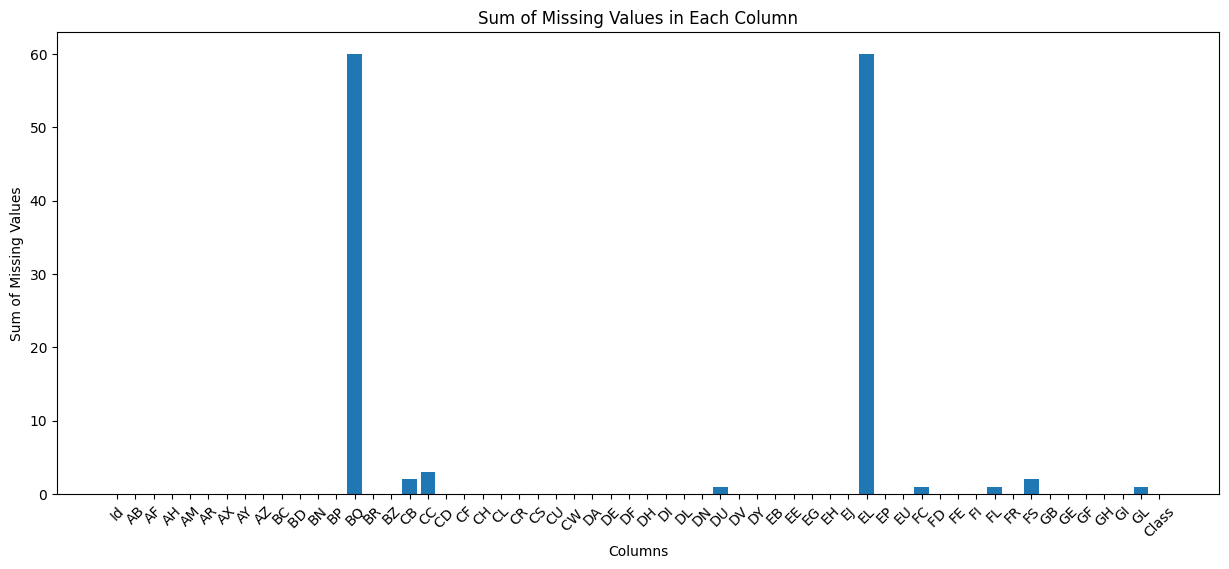

In [14]:
missing_values_sum = train_df.isnull().sum()

# Plotting the sum of missing values
plt.figure(figsize=(15, 6))
plt.bar(missing_values_sum.index, missing_values_sum.values)
plt.xlabel('Columns')
plt.ylabel('Sum of Missing Values')
plt.title('Sum of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.show()


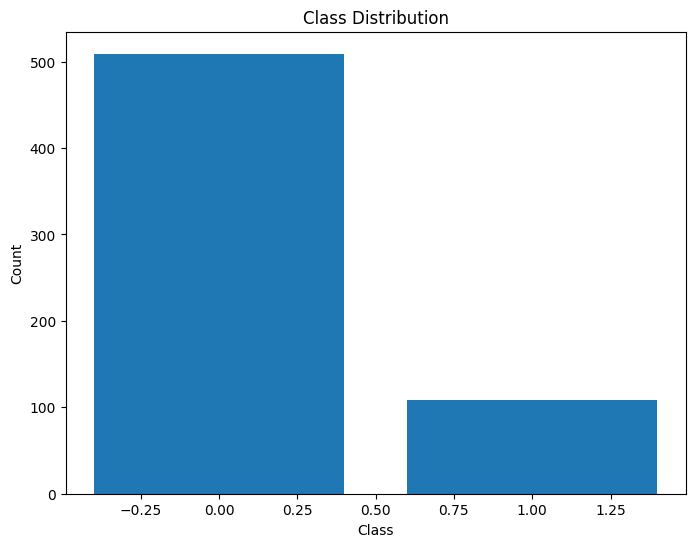

In [15]:
class_distribution = train_df['Class'].value_counts()
# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [16]:
class_distribution

0    509
1    108
Name: Class, dtype: int64

There is a huge class imbalance. We need to downsample the dataframe to have an equal amount of diagnosed/non diagnosed cases, helping our algorithms better understand patterns .

In [17]:
duplicates_train = train_df.duplicated().sum()
duplicates_train

0

In [18]:
# Find duplicates based on ID column
duplicates = train_df.duplicated(subset='Id', keep=False).sum()
print(duplicates)

0


No duplicates

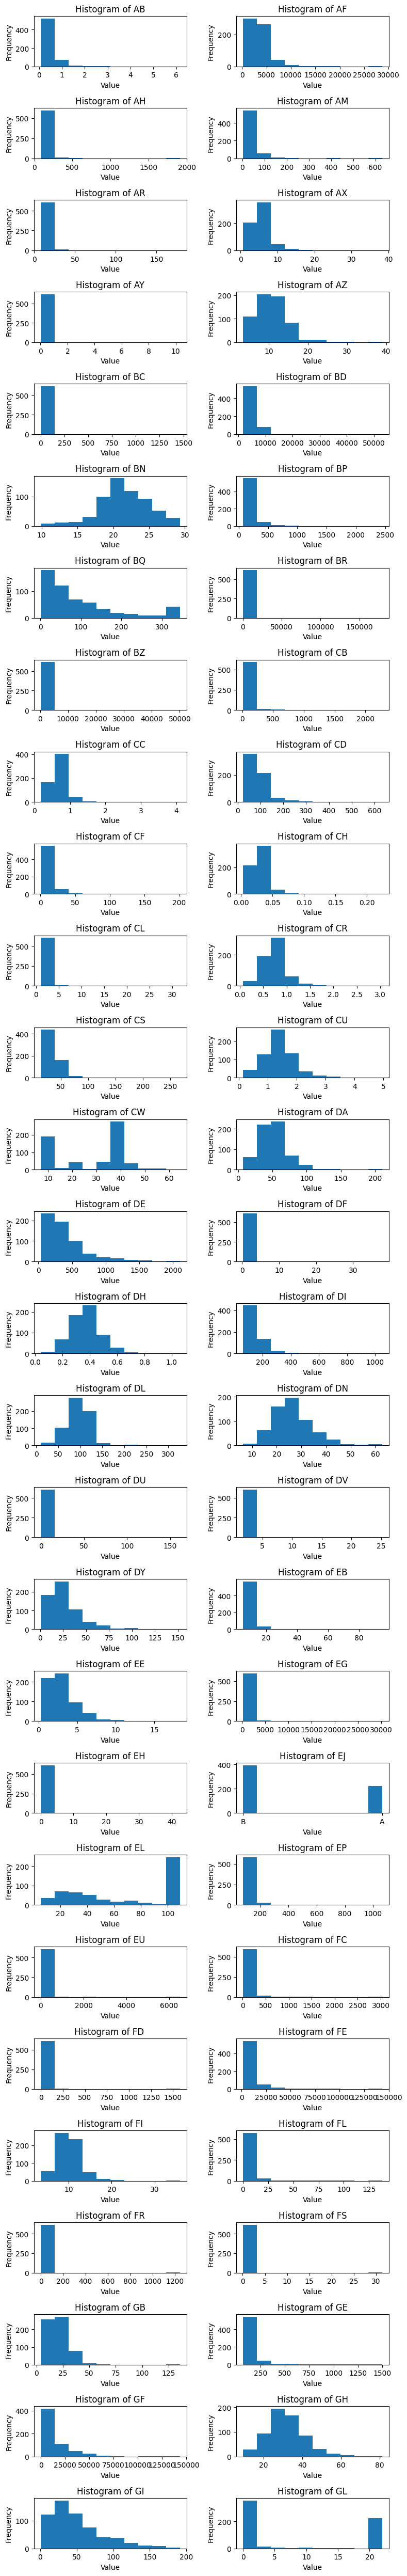

In [19]:
df= train_df.drop(['Id','Class'], axis=1)
# Determine the number of rows and columns for subplots
num_cols = df.shape[1]
num_rows = (num_cols + 1) // 2

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 50))

# Flatten the axes array if necessary
axes = axes.flatten()

# Plot histograms in subplots
for i, column in enumerate(df.columns):
    axes[i].hist(train_df[column], bins=10)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {column}')

# Remove any empty subplots
if num_cols < num_rows * 2:
    fig.delaxes(axes[-1])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

#### Correlations

<Axes: >

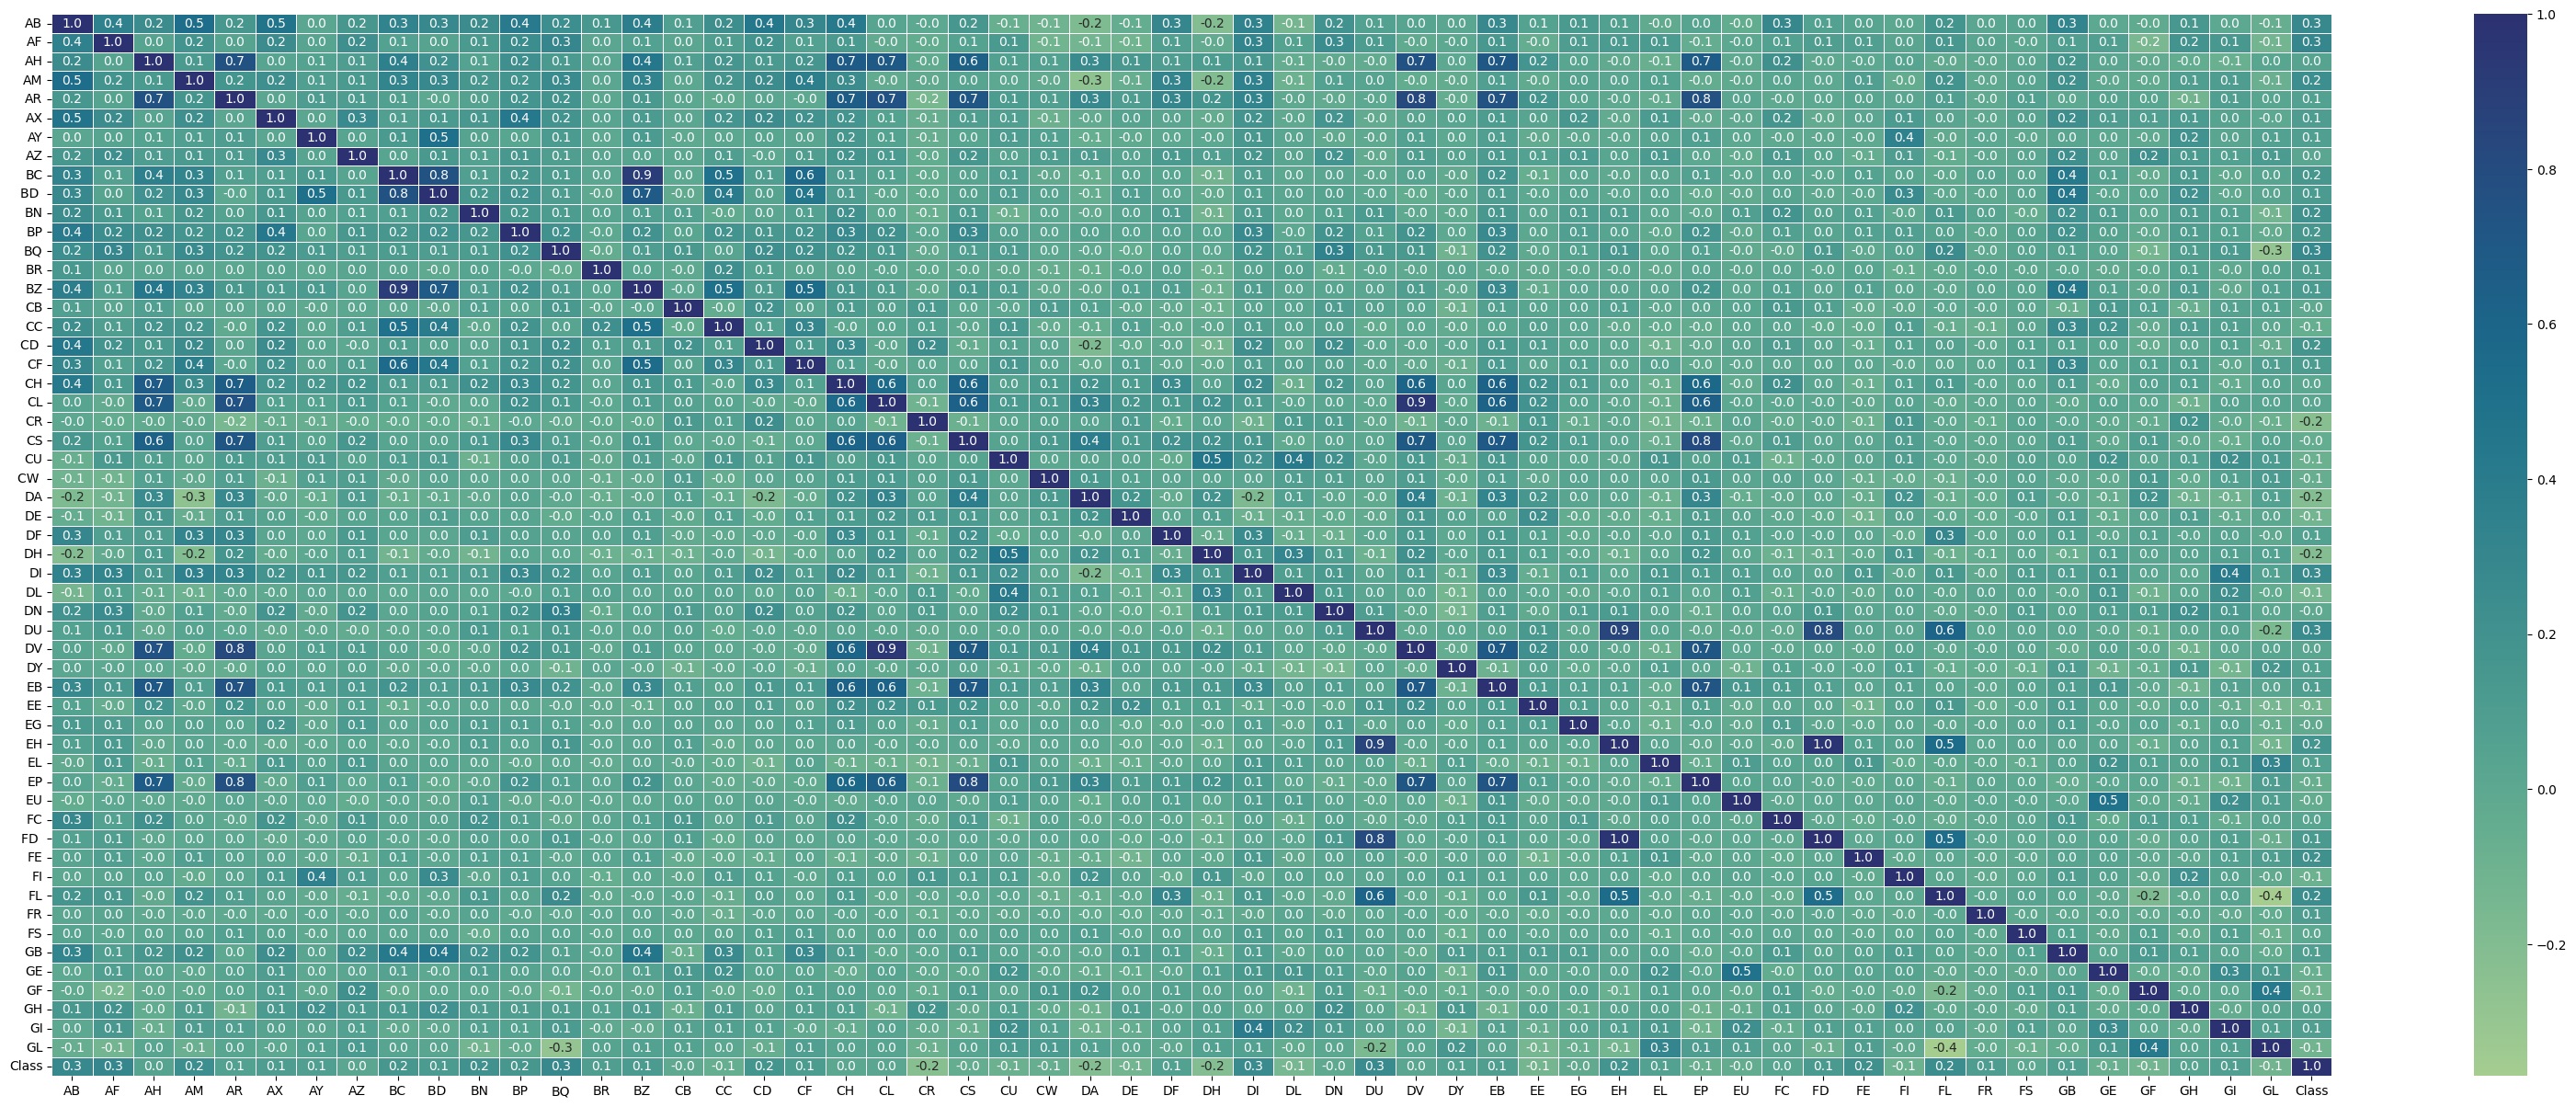

In [20]:
all_feature_corr = train_df[numeric_cols].corr()
plt.figure(figsize = (40,15))
sns.heatmap(all_feature_corr,cmap='crest',annot=True,fmt=".1f",linewidth=.5)

In [21]:
# Encode categorical features
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns
df= train_df.drop(['Id'], axis=1)
df, le_encoded_cols = label_encoder(df, None)

In [22]:
df.shape

(617, 57)

In [23]:
df.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [24]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Find the correlated variables
correlated_variables1 = set()
correlated_variables2 = set()
n_variables = len(correlation_matrix.columns)

for i in range(n_variables):
    for j in range(i + 1, n_variables):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Set your correlation threshold here
            variable_1 = correlation_matrix.columns[i]
            variable_2 = correlation_matrix.columns[j]
            correlated_variables1.add(variable_1)
            correlated_variables2.add(variable_2)
print(f"correlated_variables1 {correlated_variables1 } " )
print(f"correlated_variables2 {correlated_variables2 }  ")


correlated_variables1 {'EH', 'AR', 'DU', 'EJ', 'CL', 'BC'} 
correlated_variables2 {'DV', 'GL', 'BZ', 'EH', 'FD '}  


We observe that features are highly correlated to each other. And also we see the correlation of the Class with all the other features.

In [25]:
drop_correlated_variables1=list(correlated_variables1)
df.drop(drop_correlated_variables1, axis=1, inplace=True)

In [26]:
df.shape

(617, 51)

There are missing values in the dataset. Since the volume of data is low , we can use the greek.csv file metadata to gather information and come up with a strategy to impute missing values instead of cold dropping them. Or create a model that predicts the missing values .

 Feature Technicalities:
 Using the original dataframe will cause the following issues:
Overfitting: Our classification models will assume that in most cases there are no diagnosis ! What we want for our model is to be certain when one of the disease is diagnosed .


Wrong Correlations: Although we don't know what the features stand for, it will be useful to understand how each of this features influence the result. By having an imbalanced dataset we will not able to see the true correlations between the class and features.

We need to downsample to have a balanced dataset.

Note: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 108 from 509 non-diagnosed.)

Scaling:

*    To search for more succinct representations of the data, we are looking for algorithms - PCA / umap/ tSNE
Or, we go ahead with all the dimensions and build our feature set.

Feature Engineering- New features can be engineered. Lets say we find what is the range for feature AF for all the Id's with class 1 and class 0 respectively. Then the difference from the mean could be used as a feature. Find if this new feature correlates with the class.This can be experimented with other features.

*   Scaling

Currently, models like XGBoost and random forest are used to predict medical conditions yet the models' performance is not good enough. Dealing with critical problems where lives are on the line, models need to make correct predictions reliably and consistently between different cases.


Splitting the Data (Original DataFrame)

Before proceeding with the Random UnderSampling technique/other sampling techniques we have to separate the orginal dataframe. Why? for testing purposes, Although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.


Ensemble Modelling
Cross fold validation











In [27]:
df = df.dropna(axis=0)

In [28]:
correlation_matrix['Class'].sort_values(ascending=False).head(10)

Class    1.000000
AF       0.302638
BQ       0.281257
AB       0.280612
DU       0.261000
DI       0.260760
FL       0.244185
AM       0.239170
FE       0.216359
BN       0.198283
Name: Class, dtype: float64

In [29]:
! pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
ss = StandardScaler()

In [33]:
# Create train/test(validation) split to avoid bias in predictions
X = df.copy()

X.drop('Class', axis = 1, inplace=True)
y = df['Class'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1999)

# We want to standardise/normalise our data for the features (mean = 0 and sd = 1) so that they are of similar scale

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, predictions= model.fit(X_train_scaled, X_test_scaled, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 17.40it/s]


In [34]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [35]:
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, predictions= model.fit(X_train_scaled, X_test_scaled, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 19.66it/s]


In [36]:
print(listofmodels)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.94               0.90     0.90      0.94   
LGBMClassifier                     0.95               0.89     0.89      0.95   
XGBClassifier                      0.95               0.88     0.88      0.94   
LogisticRegression                 0.93               0.85     0.85      0.93   
NearestCentroid                    0.89               0.85     0.85      0.89   
LinearSVC                          0.92               0.85     0.85      0.92   
LinearDiscriminantAnalysis         0.92               0.83     0.83      0.92   
BernoulliNB                        0.87               0.82     0.82      0.88   
RidgeClassifierCV                  0.91               0.80     0.80      0.90   
RidgeClassifier                    0.91               0.80     0.80      0.90   
RandomForestClassifier      

In [37]:
# Graph comparing accuracy of each model from LazyClassifier
import plotly.express as px

listofmodels.sort_values('Accuracy', inplace = True, ascending = False)
graph1 = px.line(listofmodels, y =['Accuracy'], markers = True)
graph1.update_xaxes(title = 'Model Approach')
graph1.update_yaxes(title = 'Accuracy of Model')
graph1.update_layout(title = 'Accuracy of Model Approaches', showlegend = True)
graph1.show()